# DebertaV3 Analysis Report

- [Huggingface DebertaV2model code](https://github.com/anotherchudov/feedback/blob/sergei/models_training/longformer/sumbission/codes/new_transformers_branch/transformers/src/transformers/models/deberta_v2/modeling_deberta_v2.py#L994) 

- Is it ok to use max_relative_position?

```python

class DebertaV2Model(DebertaV2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        self.embeddings = DebertaV2Embeddings(config)
        self.encoder = DebertaV2Encoder(config)
        
    def forward():
        embedding_output = self.embeddings(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            mask=attention_mask,
            inputs_embeds=inputs_embeds,
        )

        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask,
            output_hidden_states=True,
            output_attentions=output_attentions,
            return_dict=return_dict,
        )
```

In [26]:
import easydict
import numpy as np

import torch
from torch import nn

## Configuration

In [14]:
deberta_config = {
    "model_type": "deberta-v2",
    "attention_probs_dropout_prob": 0.1,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.1,
    "hidden_size": 1024,
    "initializer_range": 0.02,
    "intermediate_size": 4096,
    "max_position_embeddings": 512,
    "relative_attention": True,
    "position_buckets": 256,
    "norm_rel_ebd": "layer_norm",
    "share_att_key": True,
    "pos_att_type": "p2c|c2p",
    "layer_norm_eps": 1e-7,
    "max_relative_positions": -1,
    "position_biased_input": False,
    "num_attention_heads": 16,
    "num_hidden_layers": 24,
    "type_vocab_size": 0,
    "vocab_size": 128100,
}

config = easydict.EasyDict(deberta_config)

## self.embeddings `position_ids` is ok?

> the model `position_ids` is set to [0, 1, ..., 510, 511]

when we use relative position embedding we don't use absolute position embedding so `position_biased_input` option is turned off. totally fine. This won't be applied why training.

```python
if self.position_biased_input:
      embeddings += position_embeddings
```

## Max Relative Position

> embedding is done by which bucket does token is part of, not by each token position

In [21]:
class BertEncoder(nn.Module):
    """Modified BertEncoder with relative position bias support"""

    def __init__(self, config):
        super().__init__()
        
        # initialize model layers
#         self.layer = nn.ModuleList(
#             [BertLayer(config) for _ in range(config.num_hidden_layers)]
#         )
        
        self.relative_attention = getattr(config, "relative_attention", False)
        if self.relative_attention:
            self.max_relative_positions = getattr(config, "max_relative_positions", -1)

            if self.max_relative_positions < 1:
                self.max_relative_positions = config.max_position_embeddings
                self.position_buckets = getattr(config, "position_buckets", -1)
                pos_ebd_size = self.max_relative_positions * 2

                if self.position_buckets > 0:
                    pos_ebd_size = self.position_buckets * 2

            self.rel_embeddings = nn.Embedding(pos_ebd_size, config.hidden_size)

#         self.norm_rel_ebd = [
#             x.strip()
#             for x in getattr(config, "norm_rel_ebd", "none").lower().split("|")
#         ]
#         if "layer_norm" in self.norm_rel_ebd:
#             self.LayerNorm = LayerNorm(
#                 config.hidden_size, config.layer_norm_eps, elementwise_affine=True
#             )

#         kernel_size = getattr(config, "conv_kernel_size", 0)
#         self.with_conv = False
#         if kernel_size > 0:
#             self.with_conv = True
#             self.conv = ConvLayer(config)

    def get_rel_embedding(self):
        rel_embeddings = self.rel_embeddings.weight if self.relative_attention else None
        if rel_embeddings is not None and ("layer_norm" in self.norm_rel_ebd):
            rel_embeddings = self.LayerNorm(rel_embeddings)
        return rel_embeddings

    def get_attention_mask(self, attention_mask):
        if attention_mask.dim() <= 2:
            extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
            attention_mask = extended_attention_mask * extended_attention_mask.squeeze(
                -2
            ).unsqueeze(-1)
            attention_mask = attention_mask.byte()
        elif attention_mask.dim() == 3:
            attention_mask = attention_mask.unsqueeze(1)

        return attention_mask

    def get_rel_pos(self, hidden_states, query_states=None, relative_pos=None):
        if self.relative_attention and relative_pos is None:
            q = (
                query_states.size(-2)
                if query_states is not None
                else hidden_states.size(-2)
            )
            relative_pos = build_relative_position(
                q,
                hidden_states.size(-2),
                bucket_size=self.position_buckets,
                max_position=self.max_relative_positions,
            )
        return relative_pos

    def forward(
        self,
        hidden_states,
        attention_mask,
        output_all_encoded_layers=True,
        return_att=False,
        query_states=None,
        relative_pos=None,
    ):
        if attention_mask.dim() <= 2:
            input_mask = attention_mask
        else:
            input_mask = (attention_mask.sum(-2) > 0).byte()
        attention_mask = self.get_attention_mask(attention_mask)
        relative_pos = self.get_rel_pos(hidden_states, query_states, relative_pos)

        all_encoder_layers = []
        att_matrices = []
        if isinstance(hidden_states, Sequence):
            next_kv = hidden_states[0]
        else:
            next_kv = hidden_states
        rel_embeddings = self.get_rel_embedding()
        for i, layer_module in enumerate(self.layer):
            output_states = layer_module(
                next_kv,
                attention_mask,
                return_att,
                query_states=query_states,
                relative_pos=relative_pos,
                rel_embeddings=rel_embeddings,
            )
            if return_att:
                output_states, att_m = output_states

            if i == 0 and self.with_conv:
                prenorm = output_states  # output['prenorm_states']
                output_states = self.conv(hidden_states, prenorm, input_mask)

            if query_states is not None:
                query_states = output_states
                if isinstance(hidden_states, Sequence):
                    next_kv = hidden_states[i + 1] if i + 1 < len(self.layer) else None
            else:
                next_kv = output_states

            if output_all_encoded_layers:
                all_encoder_layers.append(output_states)
                if return_att:
                    att_matrices.append(att_m)
        if not output_all_encoded_layers:
            all_encoder_layers.append(output_states)
            if return_att:
                att_matrices.append(att_m)
        return {"hidden_states": all_encoder_layers, "attention_matrices": att_matrices}

In [141]:
bert = BertEncoder(config)
bert

BertEncoder(
  (rel_embeddings): Embedding(512, 1024)
)

In [29]:
def make_log_bucket_position(relative_pos, bucket_size, max_position):
    sign = np.sign(relative_pos)
    mid = bucket_size // 2
    
    abs_pos = np.where((relative_pos < mid) & (relative_pos > -mid), mid - 1, np.abs(relative_pos))
    log_pos = np.ceil(np.log(abs_pos / mid) / np.log((max_position - 1) / mid) * (mid - 1)) + mid
    bucket_pos = np.where(abs_pos <= mid, relative_pos, log_pos * sign).astype(np.int)
    
    return bucket_pos

In [73]:
def build_relative_position(query_size, key_size, bucket_size=-1, max_position=-1):
    """
    Build relative position according to the query and key
    - we assume the absolute position of query [ P query ] is range from (0, query_size)
    - and the absolute position of key [ P key ] is range from (0, key_size)
    
    The relative positions from query to key is [ R query -> key ] = P query - P key

    Args:
        query_size (int): the length of query
        key_size (int): the length of key
        bucket_size (int): the size of position bucket
        max_position (int): the maximum allowed absolute position
    Return:
        `torch.LongTensor`: A tensor with shape [1, query_size, key_size]
    """
    q_ids = np.arange(0, query_size)
    k_ids = np.arange(0, key_size)
    rel_pos_ids = q_ids[:, None] - np.tile(k_ids, (q_ids.shape[0], 1))
    
    print('relative positional ids')
    print(rel_pos_ids)
    if bucket_size > 0 and max_position > 0:
        rel_pos_ids = make_log_bucket_position(rel_pos_ids, bucket_size, max_position)

    rel_pos_ids = torch.tensor(rel_pos_ids, dtype=torch.long)
    rel_pos_ids = rel_pos_ids[:query_size, :]
    rel_pos_ids = rel_pos_ids.unsqueeze(0)

    return rel_pos_ids

In [74]:
config.position_buckets, config.max_position_embeddings

(256, 512)

### bucket with 512 max relative position & 512 input length

In [75]:
bucket_pos = build_relative_position(
    query_size=512,
    key_size=512,
    bucket_size=config.position_buckets,
    max_position=config.max_position_embeddings,  # alternative for max_relative_embeddings
)

relative positional ids
[[   0   -1   -2 ... -509 -510 -511]
 [   1    0   -1 ... -508 -509 -510]
 [   2    1    0 ... -507 -508 -509]
 ...
 [ 509  508  507 ...    0   -1   -2]
 [ 510  509  508 ...    1    0   -1]
 [ 511  510  509 ...    2    1    0]]


In [76]:
pretrained_bucket_values = bucket_pos[:, 0, :][0].numpy()

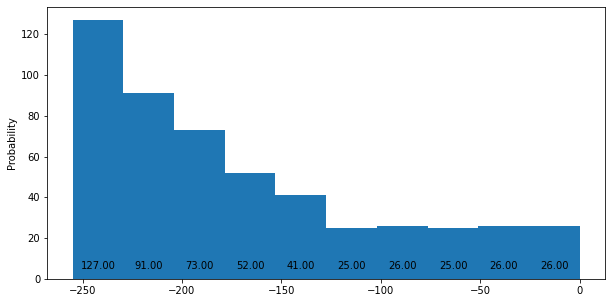

In [77]:
# code from https://stackoverflow.com/questions/48026056/visualize-matplotlib-histogram-bin-counts-directly-on-the-graph

import matplotlib.pyplot as plt              
import numpy as np                                       

plt.figure(figsize=(10, 5))

counts, bins, patches = plt.hist(pretrained_bucket_values)
plt.ylabel('Probability')


# Label the raw counts and the percentages below the x-axis...
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
for count, x in zip(counts, bin_centers):
    # Label the raw counts
    plt.annotate('{:.2f}'.format(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, 18), textcoords='offset points', va='top', ha='center')

plt.show()

In [78]:
pretrained_bucket_values[-100:]

array([-236, -236, -236, -236, -237, -237, -237, -237, -238, -238, -238,
       -238, -238, -239, -239, -239, -239, -239, -240, -240, -240, -240,
       -241, -241, -241, -241, -241, -242, -242, -242, -242, -242, -243,
       -243, -243, -243, -243, -244, -244, -244, -244, -244, -245, -245,
       -245, -245, -245, -246, -246, -246, -246, -246, -247, -247, -247,
       -247, -247, -248, -248, -248, -248, -248, -249, -249, -249, -249,
       -249, -250, -250, -250, -250, -250, -251, -251, -251, -251, -251,
       -251, -252, -252, -252, -252, -252, -253, -253, -253, -253, -253,
       -254, -254, -254, -254, -254, -254, -255, -255, -255, -255, -255,
       -255])

### bucket with 512 max relative position & 2048 input length

In [155]:
bucket_pos = build_relative_position(
    query_size=2048,
    key_size=2048,
    bucket_size=config.position_buckets,
    max_position=config.max_position_embeddings,  # alternative for max_relative_embeddings
)

relative positional ids
[[    0    -1    -2 ... -2045 -2046 -2047]
 [    1     0    -1 ... -2044 -2045 -2046]
 [    2     1     0 ... -2043 -2044 -2045]
 ...
 [ 2045  2044  2043 ...     0    -1    -2]
 [ 2046  2045  2044 ...     1     0    -1]
 [ 2047  2046  2045 ...     2     1     0]]


In [157]:
bucket_pos

tensor([[[   0,   -1,   -2,  ..., -383, -383, -383],
         [   1,    0,   -1,  ..., -383, -383, -383],
         [   2,    1,    0,  ..., -383, -383, -383],
         ...,
         [ 383,  383,  383,  ...,    0,   -1,   -2],
         [ 383,  383,  383,  ...,    1,    0,   -1],
         [ 383,  383,  383,  ...,    2,    1,    0]]])

In [80]:
finetuned_bucket_values = bucket_pos[:, 0, :][0].numpy()

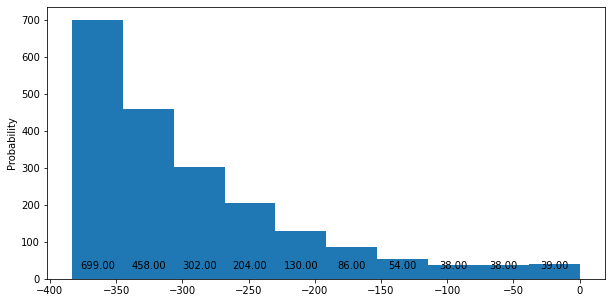

In [81]:
# code from https://stackoverflow.com/questions/48026056/visualize-matplotlib-histogram-bin-counts-directly-on-the-graph

import matplotlib.pyplot as plt              
import numpy as np                                       

plt.figure(figsize=(10, 5))

counts, bins, patches = plt.hist(finetuned_bucket_values)
plt.ylabel('Probability')


# Label the raw counts and the percentages below the x-axis...
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
for count, x in zip(counts, bin_centers):
    # Label the raw counts
    plt.annotate('{:.2f}'.format(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, 18), textcoords='offset points', va='top', ha='center')

plt.show()

In [82]:
finetuned_bucket_values[:100]

array([  0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11, -12,
       -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25,
       -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38,
       -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51,
       -52, -53, -54, -55, -56, -57, -58, -59, -60, -61, -62, -63, -64,
       -65, -66, -67, -68, -69, -70, -71, -72, -73, -74, -75, -76, -77,
       -78, -79, -80, -81, -82, -83, -84, -85, -86, -87, -88, -89, -90,
       -91, -92, -93, -94, -95, -96, -97, -98, -99])

In [83]:
finetuned_bucket_values[100:200]

array([-100, -101, -102, -103, -104, -105, -106, -107, -108, -109, -110,
       -111, -112, -113, -114, -115, -116, -117, -118, -119, -120, -121,
       -122, -123, -124, -125, -126, -127, -128, -129, -130, -131, -131,
       -132, -133, -133, -134, -135, -135, -136, -137, -137, -138, -139,
       -139, -140, -141, -141, -142, -142, -143, -144, -144, -145, -145,
       -146, -147, -147, -148, -148, -149, -150, -150, -151, -151, -152,
       -152, -153, -153, -154, -155, -155, -156, -156, -157, -157, -158,
       -158, -159, -159, -160, -160, -161, -161, -162, -162, -163, -163,
       -164, -164, -165, -165, -166, -166, -167, -167, -168, -168, -169,
       -169])

In [84]:
finetuned_bucket_values[200:300]

array([-169, -170, -170, -171, -171, -172, -172, -173, -173, -173, -174,
       -174, -175, -175, -176, -176, -177, -177, -177, -178, -178, -179,
       -179, -179, -180, -180, -181, -181, -181, -182, -182, -183, -183,
       -183, -184, -184, -185, -185, -185, -186, -186, -187, -187, -187,
       -188, -188, -188, -189, -189, -190, -190, -190, -191, -191, -191,
       -192, -192, -192, -193, -193, -194, -194, -194, -195, -195, -195,
       -196, -196, -196, -197, -197, -197, -198, -198, -198, -199, -199,
       -199, -200, -200, -200, -201, -201, -201, -202, -202, -202, -203,
       -203, -203, -204, -204, -204, -204, -205, -205, -205, -206, -206,
       -206])

### Comparing bucket location

> we can know that bucket value of pretrained is same with bucket value of finetuned one if only the position length between two token is less or same than 255

In [114]:
bucket_value = -150
print(f'pretrained bucket value {bucket_value} was in location {np.where(pretrained_bucket_values == bucket_value)[0].tolist()}')
print(f'finetuned bucket value {bucket_value} was in location {np.where(finetuned_bucket_values == bucket_value)[0].tolist()}')

pretrained bucket value -150 was in location [161, 162]
finetuned bucket value -150 was in location [161, 162]


In [115]:
bucket_value = -255
print(f'pretrained bucket value {bucket_value} was in location {np.where(pretrained_bucket_values == bucket_value)[0].tolist()}')
print(f'finetuned bucket value {bucket_value} was in location {np.where(finetuned_bucket_values == bucket_value)[0].tolist()}')

pretrained bucket value -255 was in location [506, 507, 508, 509, 510, 511]
finetuned bucket value -255 was in location [506, 507, 508, 509, 510, 511]


In [116]:
bucket_value = -256
print(f'pretrained bucket value {bucket_value} was in location {np.where(pretrained_bucket_values == bucket_value)[0].tolist()}')
print(f'finetuned bucket value {bucket_value} was in location {np.where(finetuned_bucket_values == bucket_value)[0].tolist()}')

pretrained bucket value -256 was in location []
finetuned bucket value -256 was in location [512, 513, 514, 515, 516]


In [117]:
bucket_value = -300
print(f'pretrained bucket value {bucket_value} was in location {np.where(pretrained_bucket_values == bucket_value)[0].tolist()}')
print(f'finetuned bucket value {bucket_value} was in location {np.where(finetuned_bucket_values == bucket_value)[0].tolist()}')

pretrained bucket value -300 was in location []
finetuned bucket value -300 was in location [826, 827, 828, 829, 830, 831, 832, 833, 834]


In [120]:
bucket_value = -383
print(f'pretrained bucket value {bucket_value} was in location {np.where(pretrained_bucket_values == bucket_value)[0].tolist()}')
print(f'finetuned bucket value {bucket_value} was in location {np.where(finetuned_bucket_values == bucket_value)[0].tolist()}')

pretrained bucket value -383 was in location []
finetuned bucket value -383 was in location [2041, 2042, 2043, 2044, 2045, 2046, 2047]


In [122]:
bucket_value = -384
print(f'pretrained bucket value {bucket_value} was in location {np.where(pretrained_bucket_values == bucket_value)[0].tolist()}')
print(f'finetuned bucket value {bucket_value} was in location {np.where(finetuned_bucket_values == bucket_value)[0].tolist()}')

pretrained bucket value -384 was in location []
finetuned bucket value -384 was in location []


## Bert Layer

```python
class BertLayer(nn.Module):
    def __init__(self, config):
        super(BertLayer, self).__init__()
        self.attention = BertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(
        self,
        hidden_states,
        attention_mask,
        return_att=False,
        query_states=None,
        relative_pos=None,
        rel_embeddings=None,
    ):
        attention_output = self.attention(
            hidden_states,
            attention_mask,
            return_att=return_att,
            query_states=query_states,
            relative_pos=relative_pos,
            rel_embeddings=rel_embeddings,
        )
```

```python
class BertAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self = DisentangledSelfAttention(config)
        self.output = BertSelfOutput(config)
        self.config = config

    def forward(
        self,
        hidden_states,
        attention_mask,
        return_att=False,
        query_states=None,
        relative_pos=None,
        rel_embeddings=None,
    ):
        output = self.self(
            hidden_states,
            attention_mask,
            return_att,
            query_states=query_states,
            relative_pos=relative_pos,
            rel_embeddings=rel_embeddings,  # nn.Embedding(pos_ebd_size, config.hidden_size)
        )
```

- [class DisentangledSelfAttention](https://github.com/microsoft/DeBERTa/blob/master/DeBERTa/deberta/disentangled_attention.py#L28)

```python
class DisentangledSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.num_attention_heads = config.num_attention_heads
        _attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.attention_head_size = getattr(config, 'attention_head_size', _attention_head_size)
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.query_proj = nn.Linear(config.hidden_size, self.all_head_size, bias=True)
        self.key_proj = nn.Linear(config.hidden_size, self.all_head_size, bias=True)
        self.value_proj = nn.Linear(config.hidden_size, self.all_head_size, bias=True)

        self.relative_attention = getattr(config, 'relative_attention', False)

        if self.relative_attention:
            self.position_buckets = getattr(config, 'position_buckets', -1)
            self.max_relative_positions = getattr(config, 'max_relative_positions', -1)
            if self.max_relative_positions <1:
                self.max_relative_positions = config.max_position_embeddings
            self.pos_ebd_size = self.max_relative_positions
            if self.position_buckets>0:
                self.pos_ebd_size = self.position_buckets
                # For backward compitable

            self.pos_dropout = StableDropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, attention_mask, return_att=False, query_states=None, relative_pos=None, rel_embeddings=None):
        if query_states is None:
            query_states = hidden_states

        query_layer = self.transpose_for_scores(self.query_proj(query_states), self.num_attention_heads).float()
        key_layer = self.transpose_for_scores(self.key_proj(hidden_states), self.num_attention_heads).float()
        value_layer = self.transpose_for_scores(self.value_proj(hidden_states), self.num_attention_heads)
        
        rel_att = None
        scale = 1/math.sqrt(query_layer.size(-1)*scale_factor)
        attention_scores = torch.bmm(query_layer, key_layer.transpose(-1, -2)*scale)
        if self.relative_attention:
            rel_embeddings = self.pos_dropout(rel_embeddings)
            rel_att = self.disentangled_attention_bias(query_layer, key_layer, relative_pos, rel_embeddings, scale_factor)
```

pos_ebd_size turns to 256 here

In [ ]:
def disentangled_attention_bias(self, query_layer, key_layer, relative_pos, rel_embeddings, scale_factor):
        if relative_pos is None:
            q = query_layer.size(-2)
            relative_pos = build_relative_position(q, key_layer.size(-2), bucket_size = self.position_buckets, max_position = self.max_relative_positions)
        if relative_pos.dim()==2:
            relative_pos = relative_pos.unsqueeze(0).unsqueeze(0)
        elif relative_pos.dim()==3:
            relative_pos = relative_pos.unsqueeze(1)
        # bxhxqxk
        elif relative_pos.dim()!=4:
            raise ValueError(f'Relative postion ids must be of dim 2 or 3 or 4. {relative_pos.dim()}')

        att_span = self.pos_ebd_size
        relative_pos = relative_pos.long().to(query_layer.device)

        rel_embeddings = rel_embeddings[self.pos_ebd_size - att_span:self.pos_ebd_size + att_span, :].unsqueeze(0) #.repeat(query_layer.size(0)//self.num_attention_heads, 1, 1)
        if self.share_att_key:
            pos_query_layer = self.transpose_for_scores(self.query_proj(rel_embeddings), self.num_attention_heads)\
                .repeat(query_layer.size(0)//self.num_attention_heads, 1, 1) #.split(self.all_head_size, dim=-1)
            pos_key_layer = self.transpose_for_scores(self.key_proj(rel_embeddings), self.num_attention_heads)\
                .repeat(query_layer.size(0)//self.num_attention_heads, 1, 1) #.split(self.all_head_size, dim=-1)
        else:
            if 'c2p' in self.pos_att_type or 'p2p' in self.pos_att_type:
                pos_key_layer = self.transpose_for_scores(self.pos_key_proj(rel_embeddings), self.num_attention_heads)\
                    .repeat(query_layer.size(0)//self.num_attention_heads, 1, 1) #.split(self.all_head_size, dim=-1)
            if 'p2c' in self.pos_att_type or 'p2p' in self.pos_att_type:
                pos_query_layer = self.transpose_for_scores(self.pos_query_proj(rel_embeddings), self.num_attention_heads)\
                    .repeat(query_layer.size(0)//self.num_attention_heads, 1, 1) #.split(self.all_head_size, dim=-1)

        score = 0
        # content -> position
        if 'c2p' in self.pos_att_type:
            scale = 1/math.sqrt(pos_key_layer.size(-1)*scale_factor)
            c2p_att = torch.bmm(query_layer, pos_key_layer.transpose(-1, -2).to(query_layer)*scale)
            c2p_pos = torch.clamp(relative_pos + att_span, 0, att_span*2-1)
            c2p_att = torch.gather(c2p_att, dim=-1, index=c2p_pos.squeeze(0).expand([query_layer.size(0), query_layer.size(1), relative_pos.size(-1)]))
            score += c2p_att

        # position -> content
        if 'p2c' in self.pos_att_type or 'p2p' in self.pos_att_type:
            scale = 1/math.sqrt(pos_query_layer.size(-1)*scale_factor)
            if key_layer.size(-2) != query_layer.size(-2):
                r_pos = build_relative_position(key_layer.size(-2), key_layer.size(-2), bucket_size = self.position_buckets, max_position = self.max_relative_positions).to(query_layer.device)
                r_pos = r_pos.unsqueeze(0)
            else:
                r_pos = relative_pos

            p2c_pos = torch.clamp(-r_pos + att_span, 0, att_span*2-1)
            if query_layer.size(-2) != key_layer.size(-2):
                pos_index = relative_pos[:, :, :, 0].unsqueeze(-1)

        if 'p2c' in self.pos_att_type:
            p2c_att = torch.bmm(key_layer, pos_query_layer.transpose(-1, -2).to(key_layer)*scale)
            p2c_att = torch.gather(p2c_att, dim=-1, index=p2c_pos.squeeze(0).expand([query_layer.size(0), key_layer.size(-2), key_layer.size(-2)])).transpose(-1,-2)
            if query_layer.size(-2) != key_layer.size(-2):
                p2c_att = torch.gather(p2c_att, dim=-2, index=pos_index.expand(p2c_att.size()[:2] + (pos_index.size(-2), key_layer.size(-2))))
            score += p2c_att

        # position -> position
        if 'p2p' in self.pos_att_type:
            pos_query = pos_query_layer[:,:,att_span:,:]
            p2p_att = torch.matmul(pos_query, pos_key_layer.transpose(-1, -2))
            p2p_att = p2p_att.expand(query_layer.size()[:2] + p2p_att.size()[2:])
            if query_layer.size(-2) != key_layer.size(-2):
                p2p_att = torch.gather(p2p_att, dim=-2, index=pos_index.expand(query_layer.size()[:2] + (pos_index.size(-2), p2p_att.size(-1))))
            p2p_att = torch.gather(p2p_att, dim=-1, index=c2p_pos.expand([query_layer.size(0), query_layer.size(1), query_layer.size(2), relative_pos.size(-1)]))
            score += p2p_att

        return score


## Pos is clamped

In [158]:
relative_pos = build_relative_position(
    query_size=2048,
    key_size=2048,
    bucket_size=config.position_buckets,
    max_position=config.max_position_embeddings,  # alternative for max_relative_embeddings
)

relative positional ids
[[    0    -1    -2 ... -2045 -2046 -2047]
 [    1     0    -1 ... -2044 -2045 -2046]
 [    2     1     0 ... -2043 -2044 -2045]
 ...
 [ 2045  2044  2043 ...     0    -1    -2]
 [ 2046  2045  2044 ...     1     0    -1]
 [ 2047  2046  2045 ...     2     1     0]]


In [159]:
relative_pos

tensor([[[   0,   -1,   -2,  ..., -383, -383, -383],
         [   1,    0,   -1,  ..., -383, -383, -383],
         [   2,    1,    0,  ..., -383, -383, -383],
         ...,
         [ 383,  383,  383,  ...,    0,   -1,   -2],
         [ 383,  383,  383,  ...,    1,    0,   -1],
         [ 383,  383,  383,  ...,    2,    1,    0]]])

In [160]:
max_relative_positions = config.max_position_embeddings
pos_ebd_size = config.position_buckets

In [161]:
att_span = pos_ebd_size
att_span

256

In [162]:
relative_pos + att_span

tensor([[[ 256,  255,  254,  ..., -127, -127, -127],
         [ 257,  256,  255,  ..., -127, -127, -127],
         [ 258,  257,  256,  ..., -127, -127, -127],
         ...,
         [ 639,  639,  639,  ...,  256,  255,  254],
         [ 639,  639,  639,  ...,  257,  256,  255],
         [ 639,  639,  639,  ...,  258,  257,  256]]])

511 (right token) - 256 (where the token is) - 0 (left token)

In [132]:
c2p_pos = torch.clamp(relative_pos + att_span, 0, att_span*2-1)
c2p_pos

tensor([[[256, 255, 254,  ...,   0,   0,   0],
         [257, 256, 255,  ...,   0,   0,   0],
         [258, 257, 256,  ...,   0,   0,   0],
         ...,
         [511, 511, 511,  ..., 256, 255, 254],
         [511, 511, 511,  ..., 257, 256, 255],
         [511, 511, 511,  ..., 258, 257, 256]]])

In [135]:
c2p_pos[0][0][:100]

tensor([256, 255, 254, 253, 252, 251, 250, 249, 248, 247, 246, 245, 244, 243,
        242, 241, 240, 239, 238, 237, 236, 235, 234, 233, 232, 231, 230, 229,
        228, 227, 226, 225, 224, 223, 222, 221, 220, 219, 218, 217, 216, 215,
        214, 213, 212, 211, 210, 209, 208, 207, 206, 205, 204, 203, 202, 201,
        200, 199, 198, 197, 196, 195, 194, 193, 192, 191, 190, 189, 188, 187,
        186, 185, 184, 183, 182, 181, 180, 179, 178, 177, 176, 175, 174, 173,
        172, 171, 170, 169, 168, 167, 166, 165, 164, 163, 162, 161, 160, 159,
        158, 157])

same position exist for 1536 times. 3 quarter of total attention

In [140]:
(c2p_pos[0][0] == 0).sum()

tensor(1536)

## Relative Embedding is right?

```python
self.rel_embeddings = nn.Embedding(pos_ebd_size, config.hidden_size)
self.LayerNorm = LayerNorm(config.hidden_size, config.layer_norm_eps)

def get_rel_embedding(self):
    rel_embeddings = self.rel_embeddings.weight if self.relative_attention else None
    if rel_embeddings is not None and ("layer_norm" in self.norm_rel_ebd):
        rel_embeddings = self.LayerNorm(rel_embeddings)
    return rel_embeddings

rel_embeddings = encoder.get_rel_embedding()
self.pos_dropout = StableDropout(config.hidden_dropout_prob)
rel_embeddings = self.pos_dropout(rel_embeddings)
```

In [144]:
bert.rel_embeddings

Embedding(512, 1024)

In [150]:
rel_embeddings = bert.rel_embeddings.weight
rel_embeddings.size()

torch.Size([512, 1024])

In [151]:
rel_embeddings

Parameter containing:
tensor([[ 0.0698,  0.3482, -1.4406,  ...,  1.4373, -0.5048, -0.6732],
        [-1.0669, -1.3299,  0.7206,  ..., -1.2796, -1.0290,  0.6135],
        [ 0.5742, -0.5303,  0.3706,  ...,  1.0502,  0.6977,  0.3621],
        ...,
        [-0.6821, -0.3887, -1.6728,  ..., -1.3490, -0.0899, -2.2291],
        [ 0.0834,  0.7432,  2.2757,  ...,  0.2183,  0.8242, -0.7037],
        [-0.1434, -0.5098, -1.7966,  ...,  0.2468, -0.8081, -0.6022]],
       requires_grad=True)

In [149]:
LayerNorm = torch.nn.LayerNorm(1024)

In [152]:
rel_embeddings = LayerNorm(rel_embeddings)

In [153]:
rel_embeddings

tensor([[ 0.0778,  0.3543, -1.4226,  ...,  1.4362, -0.4930, -0.6603],
        [-1.1001, -1.3597,  0.6642,  ..., -1.3101, -1.0626,  0.5585],
        [ 0.5074, -0.5537,  0.3117,  ...,  0.9647,  0.6260,  0.3036],
        ...,
        [-0.7295, -0.4287, -1.7453,  ..., -1.4134, -0.1224, -2.3157],
        [ 0.0607,  0.7239,  2.2642,  ...,  0.1963,  0.8053, -0.7305],
        [-0.1270, -0.4933, -1.7797,  ...,  0.2631, -0.7916, -0.5857]],
       grad_fn=<NativeLayerNormBackward>)

- [StableDropout](https://github.com/microsoft/DeBERTa/blob/master/DeBERTa/deberta/ops.py#L131-L180)
- [mask code](https://github.com/microsoft/DeBERTa/blob/master/DeBERTa/deberta/ops.py#L101)
```python
mask=(1-torch.empty_like(input).bernoulli_(1-dropout)).byte()
```

removed the some part of embedding values